# Off-Platform Project: Viral Tweets

In this project, we are going to use the K-Nearest Neighbor algorithm to predict whether a tweet will go viral. Before jumping into using the classifier, let's first consider the problem we're trying to solve. Which features of a tweet are most closely linked to its popularity? Maybe the number of hashtags or the number of links in the tweet strongly influences its popularity. Maybe its virality is dependent on how many followers the person has. Maybe it's something more subtle like the specific language used in the tweets.

Let's explore these options by looking at the data we have available to us. We've imported the dataset and printed the following information:

* The total number of tweets in the dataset.
* The columns, or features, of the dataset.
* The text of the first tweet in the dataset.

Some of these features are dictionaries. For example, the feature `"user"` is a dictionary. We might want to use some of the information found in these sub-dictionaries. Print `all_tweets.loc[0]["user"]` to see what the `"user"` feature looks like.

After printing that, try printing just the `"location"` found in that `"user"` dictionary. For example, `all_tweets.loc[0]["user"]["screen_name"]` would give you only the screen name associated with the first tweet.

In [3]:
import pandas as pd

all_tweets = pd.read_json("random_tweets.json", lines=True)

print(len(all_tweets))
print(all_tweets.columns)
print(all_tweets.loc[0]['text'])

#Print the user here and the user's location here.
print(all_tweets.loc[0]['user']['location'])

11099
Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'retweeted_status',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'lang', 'possibly_sensitive', 'quoted_status_id',
       'quoted_status_id_str', 'extended_entities', 'quoted_status',
       'withheld_in_countries'],
      dtype='object')
RT @KWWLStormTrack7: We are more than a month into summer but the days are getting shorter. The sunrise is about 25 minutes later on July 3…
Waterloo, Iowa


# Defining Viral Tweets

A K-Nearest Neighbor classifier is a supervised machine learning algorithm, and as a result, we need to have a dataset with tagged labels. For this specific example, we need a dataset where every tweet is marked as viral or not viral. Unfortunately, this isn't a feature of our dataset &mdash; we'll need to make it ourselves.

So how do we define a viral tweet? A good place to start is to look at the number of retweets the tweet has. This can be found using the feature `"retweet_count"`. Let's say we wanted to create a column called `is_viral` that is a `1` if the tweet had more than `5` retweets and `0` otherwise. We could do that like this:

```py
all_tweets['is_viral'] = np.where(all_tweets['retweet_count'] > 5, 1, 0)
```

Instead of using `5` as the benchmark for a viral tweet, let's use the median number of retweets. You can find that by calling the `median()` function on `all_tweets["retweet_count"]`. Print the median number of retweets to understand what this threshold is.

Print the number of viral tweets and non-viral tweets. You can do this using `all_tweets['is_viral'].value_counts()`.

After finishing this project, consider coming back and playing with this threshold number. How do you think your model would work if it was trying to find incredibly viral tweets? For example, how would it work if it were looking for tweets with 1000 or more retweets?

In [5]:
import numpy as np
print(np.median(all_tweets['retweet_count']))
all_tweets['is_viral'] = np.where(all_tweets['retweet_count'] > 13, 1, 0)
print(all_tweets['is_viral'].value_counts())

13.0
0    5562
1    5537
Name: is_viral, dtype: int64


# Making Features

Now that we've created a label for every tweet in our dataset, we can begin thinking about which features might determine whether a tweet is viral. We can create new columns in our dataset to represent these features. For example, let's say we think the length of a tweet might be a valuable feature. The following line creates a new column containing the length of the tweet.

```py
all_tweets['tweet_length'] = all_tweets.apply(lambda tweet: len(tweet['text']), axis=1)
```

Setting `axis = 1` creates a new column rather than a new row.

Create a new column called `followers_count` that contains the number of followers of each user. You can find this information in `tweet['user']['followers_count']`. Do the same for `friends_count`.

For the rest of this project, we will be using these three features, but we encourage you to create your own. Here are some potential ideas for more features.

* The number of hashtags in the tweet. You can find this by looking at the `text` of the tweet and using the `.count()` function with `#` as a parameter.
* The number of links in the tweet. Using a similar strategy to the one above, use `.count()` to count the number of times `http` appears in the tweet.
* The number of words in the tweet. Call `.split()` on the `text` of a tweet. This will give you a list of the words in the tweet. Find the length of that list.
* The average length of the words in the tweet.

In [10]:
all_tweets['tweet_length'] = all_tweets.apply(lambda tweet: len(tweet['text']), axis=1)
all_tweets['follower_count'] = all_tweets.apply(lambda tweet: tweet['user']['followers_count'], axis=1)
all_tweets['friends_count'] = all_tweets.apply(lambda tweet: tweet['user']['friends_count'], axis=1)

# Normalizing The Data

We've now made the columns that we want to feed into our classifier. Let's get rid of all the data that is no longer relevant. Create a variable named `labels` and set it equal to the `'is_viral'` column of all_tweets.

If we had a dataframe named `df` we could get a single column named `A` like this:

```py
one_column = df['A']
```

Create a variable named `data` and set it equal to all of the columns that you created in the last step. Those columns are `tweet_length`, `followers_count`, and `friends_count`.

When selecting multiple columns, the names of the columns should be in a list. Check out the example below to see how to select column `A` *and* `B`:

```py
features = df[['A', 'B']]
```

Now create a new variable named `scaled_data`. `scaled_data` should be the result of the `scale` function with `data` as a parameter. Also include the parameter `axis = 0`. This scales the *columns* as opposed to the rows.

The scale function will normalize the data so all of the features will vary within the same range.

Print `scaled_data[0]` to get a sense of what our data looks like.

In [14]:
from sklearn.preprocessing import scale

labels = all_tweets['is_viral']
data = all_tweets[['tweet_length', 'follower_count', 'friends_count']]

scaled_data = scale(data, axis=0)
print(scaled_data[0])

[ 0.6164054  -0.02878298 -0.14483305]


# Creating the Training Set and Test Set

To evaluate the effectiveness of our classifier, we now split `scaled_data` and `labels` into a training set and test set using scikit-learn's `train_test_split` function. This function takes two required parameters: It takes the data, followed by the labels. Set the optional parameter `test_size` to be `0.2`. You can also set the `random_state` parameter so your code will randomly split the data in the same way as our solution code splits the data. We used `random_state = 1`. Remember, this function returns 4 items in this order:

1. The training data
2. The testing data
3. The training labels
4. The testing labels

Store the results in variables named `train_data`, `test_data`, `train_labels`, and `test_labels`.

In [15]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size=0.2, random_state=1)

# Using the Classifier

We can finally use the K-Nearest Neighbor classifier. Let's test it using `k = 5`. Begin by creating a `KNeighborsClassifier` object named `classifier` with the parameter `n_neighbors` equal to `5`.

Next, train `classifier` by calling the `.fit()` method with `train_data` and `train_labels` as parameters.

Finally, let's test the model! Call `classifier`'s `.score()` method using `test_data` and `test_labels` as parameters. Print the results.


In [18]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(train_data, train_labels)
print(classifier.score(test_data, test_labels))

0.5882882882882883


# Choosing K

We've tested our classifier with `k = 5`, but maybe there's a `k` that will work better. Let's test many different values for `k` and graph the results. 

First, create an empty list called `scores`. Next, create a for loop that has a variable `k` that begins at `1` and ends at `200`.

Inside the for loop, create a `KNeighobrsClassifier` object named `classifier` with the parameter `n_neighbors` equal to `k`.

Train `classifier` by calling the `.fit()` method with `train_data` and `train_labels` as parameters.

Next, let's test the model! Call `classifier`'s `.score()` method using `test_data` and `test_labels` as parameters. `append` the result to `scores`.

Finally, let's plot the results. Outside of the loop, use Matplotlib's `plot()` function. `plot()` takes two parameters &mdash; the data on the x-axis and the data on the y-axis. Data on the x-axis should be the values we used for `k`. In this case, `range(1,200)`.  Data on the y-axis should be `scores`. Make sure to call the `plt.show()` function after calling `plt.plot()`. This should take a couple of seconds to run!

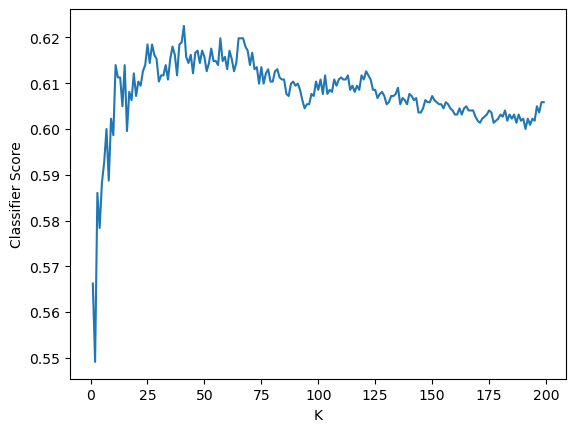

In [19]:
import matplotlib.pyplot as plt

scores= []

for k in range(1, 200):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))
    
plt.plot(range(1, 200), scores)
plt.xlabel('K')
plt.ylabel('Classifier Score')
plt.show()

# Explore on your own

Nice work! You can see the classifier gets better as `k` increases, but as `k` gets too high, underfitting starts to happen.

By using the features `tweet_length`, `followers_count`, and `friends_count`, we were able to get up to around 63% accuracy. That is better than random, but still not exceptional. Can you find some different features that perform better? Share your graphs with us on Twitter and maybe it will go viral!